# Full-Learning PC Networks
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [175]:
# Make my own dataset
A = torch.tensor([[ 1.3874, -0.2003,  0.4514],
                  [-0.0967, -0.4015,  1.3332]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [135]:
# Make my own dataset
A = torch.rand((4,9), dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [1507]:
# Make my own dataset
A = torch.eye(2, dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [3]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 0.3232, -0.9563,  0.5234,  1.4845, -0.3955,  0.9563, -0.8818, -1.4115,
          1.3157,  0.8915],
        [ 1.2468,  0.5938,  0.8025, -1.0985, -1.3189, -0.9960,  0.8459, -0.2334,
          0.5250,  1.1660],
        [-0.8239, -1.1012,  0.0545,  0.2905, -0.4973,  1.3367, -1.4346,  0.9836,
         -0.9238, -0.5371]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [226]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [227]:
blah = SimpleDataset(A, B, n=200, noise=0.1)

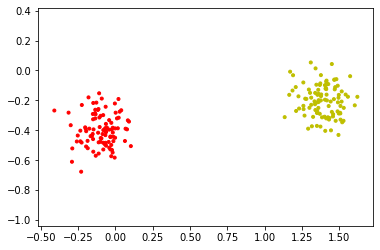

In [228]:
blah.Plot(idx=(0,1));

# Create Network

In [229]:
ds = SimpleDataset(A, B, n=200, noise=0.1)
dl = DataLoader(ds, batch_size=4, shuffle=True)

In [230]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=ds.input_dim))  # v0 input
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # e1 error
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # v1 class

af0 = 'identity'
af = 'identity'
net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text=af0)
#net.Connect(v_idx=2, e_idx=1, type='1to1')
net.Connect(e_idx=1, v_idx=2, type='general', sym=True, act_text=af)
#net.con[1].SetIdentity()

net.SetTau(0.05)

# Training

In [46]:
#net.Plot(idx=0);

In [243]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)

# Connection (v0)--(e1)
net.con[0].SetRandom(random=1.)

# Connection (e1)--(v1)
net.con[1].SetRandom(random=1.)
#net.con[1].SetIdentity(mult=0.1)
net.con[1].renormalize = True
net.con[1].ell = 1.

#net.lyr[1].SetBias(random=0.5)

net.SetDynamicWeightDecay(0., 0.8)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [244]:
M0 = deepcopy(net.con[0].M)
print(M0)
M1 = deepcopy(net.con[1].M)
print(M1)

tensor([[ 1.1155, -0.4463],
        [-0.0194,  0.3221],
        [-0.0179, -0.2995]])
tensor([[ 0.8399,  0.3613],
        [-0.6603,  0.1278]])


In [59]:
net.SetRepelSmallWeights(0.0)

In [2101]:
net.con[0].M = M0.clone().detach()
net.con[0].W = M0.transpose(1,0).clone().detach()
net.con[1].M = M1.clone().detach()
net.con[1].W = M1.transpose(1,0).clone().detach()

In [245]:
net.ClearHistory()

In [246]:
net.Learning(True)
net.con[1].Learning(True)
net.Learn(dl, T=1., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [247]:
torch.sum(torch.abs(net.con[1].M))

tensor(1.)

In [248]:
print(net.con[0].M)
print(net.con[1].M)

tensor([[ 0.4350, -0.0653],
        [-0.1344,  0.0090],
        [ 0.0805, -0.0842]])
tensor([[ 0.7008, -0.1344],
        [ 0.0666, -0.0982]])


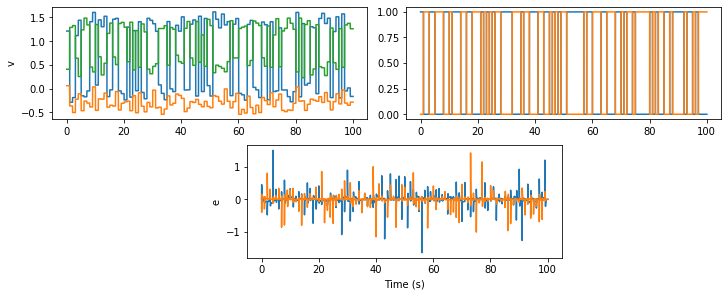

In [249]:
net.Plot(idx=0);

# Classification

In [250]:
net.Reset(random=1.)
net.SetActivityDecay( 0. )
y = net.Predict(ds.Inputs(), T=10.)
print(y[:16])
print(ds.Targets()[:16])

tensor([[ 1.0903e+00,  9.8108e-04],
        [ 9.1633e-01,  6.0004e-02],
        [ 3.1851e-02,  7.6331e-01],
        [ 1.0086e+00,  5.3415e-02],
        [ 1.0056e+00,  5.1903e-02],
        [ 2.1124e-02,  7.7975e-01],
        [ 1.0048e+00,  1.7006e-02],
        [ 9.0844e-01,  1.2371e-01],
        [ 1.0582e+00,  9.6356e-02],
        [ 8.5077e-01,  1.2258e-01],
        [ 9.3361e-01, -9.0627e-02],
        [ 9.7352e-01,  8.0440e-02],
        [ 1.5401e-01,  8.0659e-01],
        [ 8.5095e-01, -3.5248e-02],
        [ 9.8718e-01,  8.0533e-02],
        [ 6.6791e-02,  8.1088e-01]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])


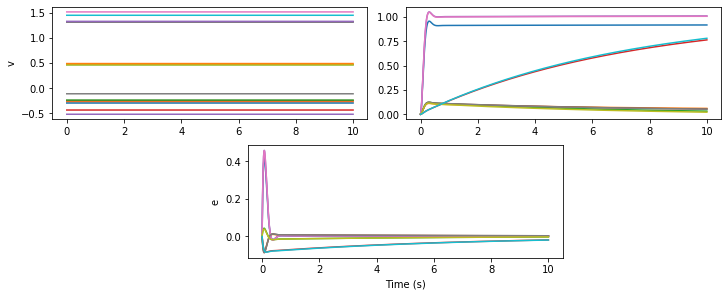

In [251]:
net.Plot(idx=[1,2,3,4,5]);

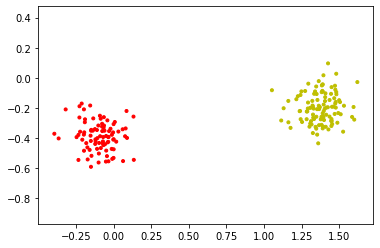

In [204]:
ds.Plot(labels=y, idx=(0,1))

# Generation

In [67]:
net.Reset(random=1.)
net.SetActivityDecay( 0.01 )
X = net.Generate(ds.Targets(), T=20)

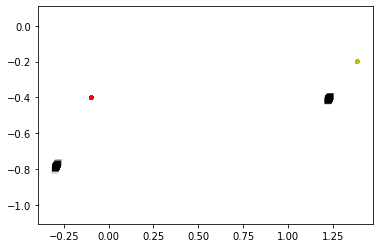

In [68]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

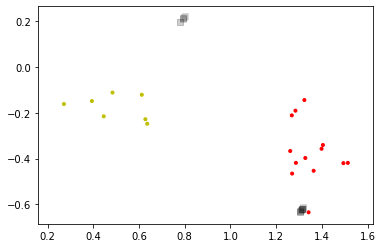

In [207]:
sidx = (2,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

In [70]:
np.linalg.svd(net.con[0].M.numpy())

(array([[-0.2791553 ,  0.94110906,  0.19075115],
        [-0.8711832 , -0.33176613,  0.36189917],
        [ 0.4038714 , -0.06515311,  0.91249275]], dtype=float32),
 array([1.7948176, 0.5198465], dtype=float32),
 array([[-0.8322415, -0.5544133],
        [ 0.5544133, -0.8322415]], dtype=float32))

# Linear Analysis

In [165]:
X = ds.Inputs().transpose(1,0)
Y = ds.Targets().transpose(1,0)

In [166]:
X.size()

torch.Size([3, 200])

In [167]:
XX = X @ X.transpose(1,0)
XY = X @ Y.transpose(1,0)
YX = Y @ X.transpose(1,0)
YY = Y @ Y.transpose(1,0)

In [168]:
Xbb_first_row = torch.cat((XX,XY), 1)
Xbb_second_row = torch.cat((YX,YY), 1)
Xbb = torch.cat((Xbb_first_row, Xbb_second_row), 0)

In [169]:
Xbb

tensor([[192.7360, -21.7756,  48.4585, 135.4664,  -9.0804],
        [-21.7756,  22.4884, -63.0774, -18.4121, -41.2082],
        [ 48.4585, -63.0774, 204.1694,  43.4494, 136.2605],
        [135.4665, -18.4121,  43.4494,  97.9196,   0.5839],
        [ -9.0804, -41.2082, 136.2605,   0.5839, 103.3818]])

In [170]:
np.linalg.matrix_rank(Xbb.numpy())

5

In [171]:
u,s,v = torch.svd(Xbb)
print(s)

tensor([362.4649, 252.3392,   2.5673,   1.9268,   1.3971])


In [172]:
evalue, evec = torch.eig(Xbb, eigenvectors=True)
print(evalue)

tensor([[362.4650,   0.0000],
        [252.3393,   0.0000],
        [  1.3971,   0.0000],
        [  2.5673,   0.0000],
        [  1.9268,   0.0000]])


In [173]:
k = 0
print(Xbb @ evec[:,k])
evalue[k,0] * evec[:,k]

tensor([180.4536, -79.0115, 237.5939, 137.2176, 131.5103])


tensor([180.4536, -79.0115, 237.5939, 137.2177, 131.5104])